In [ ]:
#RIFAT

Processing Tiger: 100%|██████████| 39/39 [00:21<00:00,  1.82it/s]


Dataset contains 170 images spanning 5 classes.


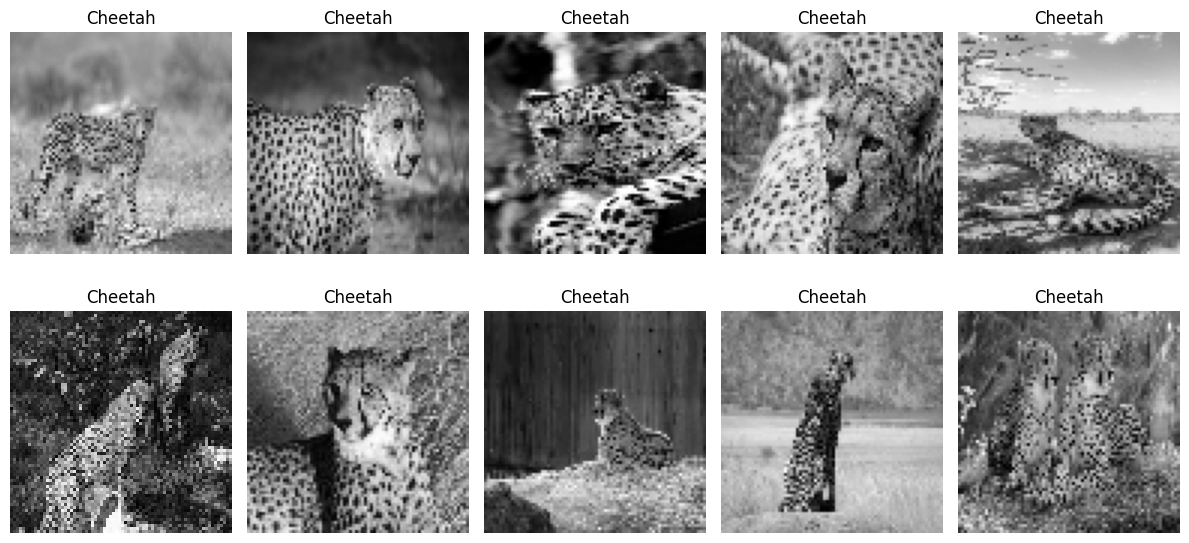

Testing K values: 100%|██████████| 30/30 [00:02<00:00, 13.61it/s]


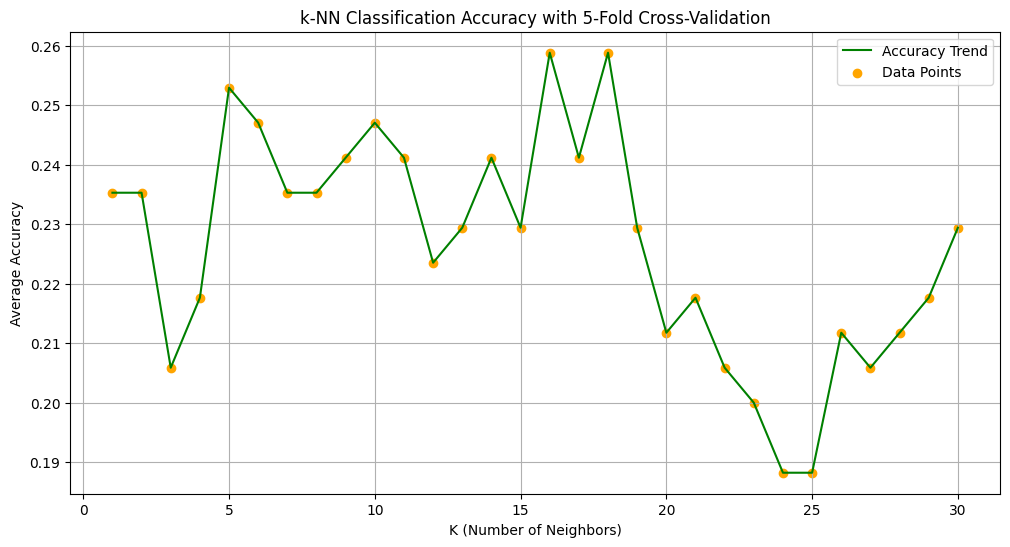

In [ ]:
#Section 1: Import Libraries

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm



#Section 2: Define Dataset Path

# Dataset directory
dataset_directory = '/content/drive/MyDrive/Animals'

# Animal categories within the dataset
animal_classes = ["Cheetah", "Jaguar", "Leopard", "Lion", "Tiger"]


#Section 3: Load and Preprocess Dataset

def fetch_images():
    img_data = []
    class_labels = []
    for category in animal_classes:
        folder_path = os.path.join(dataset_directory, category)
        for file_name in tqdm(os.listdir(folder_path), desc=f"Processing {category}"):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path)
                if img is not None:
                    resized_img = cv2.resize(img, (74, 74))
                    gray_scale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                    img_data.append(gray_scale_img)
                    class_labels.append(category)
    return np.array(img_data), np.array(class_labels)

# Load the image dataset
images_data, class_labels = fetch_images()
print(f"Dataset contains {len(images_data)} images spanning {len(animal_classes)} classes.")


#Section 4: Visualize the Dataset

def visualize_images(img_set, label_set, display_count=10):
    plt.figure(figsize=(12, 6))
    for idx in range(min(display_count, len(img_set))):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img_set[idx], cmap='gray')
        plt.title(label_set[idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of the dataset
visualize_images(images_data, class_labels, display_count=10)


#Section 5: k-NN Helper Functions

def calculate_distance(img1, img2):
    return np.linalg.norm(img1 - img2)

def knn_predict(test_img, training_data, training_labels, neighbors=3):
    distance_list = []
    for idx in range(len(training_data)):
        dist = calculate_distance(test_img, training_data[idx])
        distance_list.append((dist, training_labels[idx]))
    distance_list.sort(key=lambda x: x[0])
    top_neighbors = [label for _, label in distance_list[:neighbors]]

    # Count the frequency of labels in the top neighbors
    label_frequency = {}
    for label in top_neighbors:
        label_frequency[label] = label_frequency.get(label, 0) + 1

    # Return the label with the highest frequency
    return max(label_frequency, key=label_frequency.get)

def split_data_kfold(data, labels, folds=5):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    fold_length = len(data) // folds

    for i in range(folds):
        test_idx = indices[i * fold_length : (i + 1) * fold_length]
        train_idx = np.concatenate([indices[:i * fold_length], indices[(i + 1) * fold_length:]])
        yield data[train_idx], data[test_idx], labels[train_idx], labels[test_idx]


##Section 6: Perform 5-Fold Cross-Validation

# Evaluating different values of K for k-NN
k_range = range(1, 31)
performance = {k: [] for k in k_range}

# 5-fold cross-validation process
for train_data, test_data, train_labels, test_labels in split_data_kfold(images_data, class_labels):
    for k in tqdm(k_range, desc="Testing K values"):
        correct_count = 0
        for j in range(len(test_data)):
            result = knn_predict(test_data[j], train_data, train_labels, k)
            if result == test_labels[j]:
                correct_count += 1
        fold_accuracy = correct_count / len(test_data)
        performance[k].append(fold_accuracy)

# Compute average accuracy for each K
average_accuracy = {k: np.mean(acc) for k, acc in performance.items()}


#Section 7: Visualize Accuracy vs K

# Plot the accuracy vs K
k_vals = list(average_accuracy.keys())
accuracy_vals = list(average_accuracy.values())

plt.figure(figsize=(12, 6))
plt.plot(k_vals, accuracy_vals, label='Accuracy Trend', color='green', linestyle='-')
plt.scatter(k_vals, accuracy_vals, label='Data Points', color='orange')

plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Average Accuracy')
plt.title('k-NN Classification Accuracy with 5-Fold Cross-Validation')
plt.legend()
plt.grid(True)
plt.show()
